In [1]:
import sys
sys.path.append('..')

import os
import psutil
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
np.random.seed(0)

In [2]:
import matplotlib.pyplot as plt
from pylab import *
from keras.models import Sequential
from keras import optimizers
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, Convolution2D, Dense
from keras.models import Model
from keras.datasets import cifar10

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.preprocessing.image import ImageDataGenerator
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from custom_lib.triplet_utils import buildDataSet, build_model
from custom_lib.triplet_utils import get_batch_hard, compute_probs
from custom_lib.triplet_utils import add_top, remove_top

from art.classifiers import KerasClassifier
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer
from art.attacks.fast_gradient import FastGradientMethod

from custom_lib.build_resnet import resnet_v1, resnet_emb

Using TensorFlow backend.


In [3]:
def restrict_cpu():
    p = psutil.Process()

    for i in p.threads():
        temp = psutil.Process(i.id)

        temp.cpu_affinity([i for i in range(10,20)])

In [4]:
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
learning_rate = 5e-6
batch_size=64
epochs=10

nb_classes = 10
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
in_shape = input_shape

#dataset_train, dataset_test, x_train_origin, y_train_origin, x_test_origin, y_test_origin = buildDataSet(cifar=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


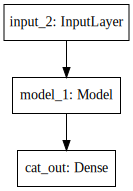

In [6]:
# -------------------- Base Model --------------------------

base_model = resnet_emb(input_shape)
base_model.load_weights("saved_models/old_base.h5")

base_in = Input(shape=in_shape)
base_out = base_model(base_in)

# -------------------- New Model ---------------------------

new_out = Dense(10, activation='softmax', name="cat_out")(base_out)

model = Model(inputs=base_in, 
              outputs=new_out, 
              name="fullnet")

model.compile(loss="categorical_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=1, 
          batch_size=32,
          verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 62s 1ms/step - loss: 0.3654 - acc: 0.9197 - val_loss: 0.4400 - val_acc: 0.8996


In [12]:
art_model = KerasClassifier(clip_values=(0, 1.), model=model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, eps=5, random_eps=True, eps_step=0.8, max_iter=6, batch_size=16)

adv_test = attack.generate(x_test[:10])

restrict_cpu()

In [13]:
def adv_batch_generator(X, Y, batch_size = 64):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices) 
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    adv_x = X[batch]
                    adv_x[:64] = attack.generate(adv_x[:64])
                    yield adv_x, Y[batch]
                    batch=[]

train_generator = adv_batch_generator(x_train, y_train, batch_size = 128)

In [10]:
'''
temp = np.copy(attack.classifier._model.layers[1].layers[7].get_weights()[0])

batch = train_generator.__next__()
    
loss = model.train_on_batch(batch[0], batch[1])

(temp == attack.classifier._model.layers[1].layers[7].get_weights()[0]).sum()
'''
None

In [41]:
for i, layer in enumerate(model.layers[1].layers[:-7]):
    layer.trainable = False
    
model.compile(loss="categorical_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [15]:
model.metrics_names

['loss', 'acc']

In [14]:
# Hyper parameters

#K.set_value(adv_model.optimizer.lr, 1e-8)

evaluate_every = 250 # interval for evaluating on one-shot tasks
n_iter = 15000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
n_iteration=0

loss_list = []
cat_vals = []
acc_vals = []

print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

for i in range(1, n_iter+1):
    
    batch = train_generator.__next__()
    
    loss = model.train_on_batch(batch[0], batch[1])
    
    cat_vals.append(loss[0])
    acc_vals.append(loss[1])
    
    n_iteration += 1
    
    if i % 8000 == 0:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/2.0)
    
    if i % evaluate_every == 0:
        ploss = (np.mean(cat_vals), np.mean(acc_vals))
        loss_list.append(ploss)
        cat_vals = []
        acc_vals = []
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,ploss,n_iteration))

Starting training process!
-------------------------------------

 ------------- 

[250] Time for 250 iterations: 2.0 mins, Train Loss: (1.8476074, 0.5565625)

 ------------- 

[500] Time for 500 iterations: 4.0 mins, Train Loss: (1.6314021, 0.54225)

 ------------- 

[750] Time for 750 iterations: 6.1 mins, Train Loss: (1.5711886, 0.5487813)

 ------------- 

[1000] Time for 1000 iterations: 8.2 mins, Train Loss: (1.4277153, 0.5833125)

 ------------- 

[1250] Time for 1250 iterations: 10.2 mins, Train Loss: (1.3752751, 0.589875)

 ------------- 

[1500] Time for 1500 iterations: 12.2 mins, Train Loss: (1.3297795, 0.5929375)

 ------------- 

[1750] Time for 1750 iterations: 14.3 mins, Train Loss: (1.2695773, 0.6145313)

 ------------- 

[2000] Time for 2000 iterations: 16.4 mins, Train Loss: (1.2271535, 0.62709373)

 ------------- 

[2250] Time for 2250 iterations: 18.4 mins, Train Loss: (1.2180816, 0.62771875)

 ------------- 

[2500] Time for 2500 iterations: 20.5 mins, Train Loss:

In [12]:
eval_loss = model.evaluate(x_test, y_test, verbose=0)

print("Base images:")
for i, name in enumerate(model.metrics_names):
    print(name, eval_loss[i])
    
losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = model.evaluate(adv_test, y_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 0.5240786637306213
acc 0.8696

Adv images:
loss 1.2284334247112274
acc 0.6005


In [42]:
eval_loss = model.evaluate(x_test, y_test, verbose=0)

print("Base images:")
for i, name in enumerate(model.metrics_names):
    print(name, eval_loss[i])
    
losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = model.evaluate(adv_test, y_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 0.5240786637306213
acc 0.8696

Adv images:
loss 3.0347892313599587
acc 0.46225


In [41]:
adv_test = attack.generate(x_test[:128])

for i in range(0, 128, 4):
    print(norm(adv_test[i] - x_test[i]))

0.006197215156541669
0.006197243855823749
0.0061972067740091435
0.006197201702287278
0.006197222693584718
0.006197235302991689
0.00619720735373796
0.006197215513875389
0.006197225669063938
0.0061972143298269725
0.006197225178481423
0.006197242504137799
0.006197238739406758
0.006197225144388643
0.006197228389528877
0.006197224125079469
0.0061972182416762025
0.0061972101946314575
0.00619723100151571
0.006197212628345494
0.006197213144013635
0.00619723060904374
0.006197242732787031
0.006197213891473591
0.006197218991405546
0.006197187412586909
0.0061972341181269425
0.006197247351868629
0.006197242019843722
0.006197218416101002
0.006197206832209025
0.006197248756918049


In [39]:
attack = ProjectedGradientDescent(art_model, norm=2, eps=2, random_eps=True, eps_step=0.2, max_iter=15, batch_size=16)

1.9999999290232593


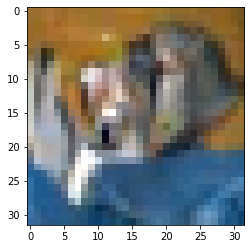

1.9999999106637287


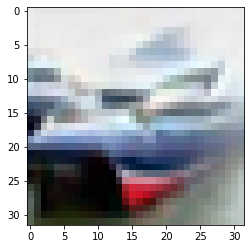

1.9999998988015772


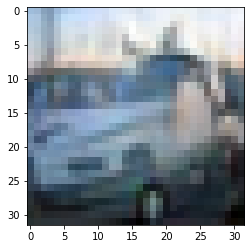

1.9999999060020972


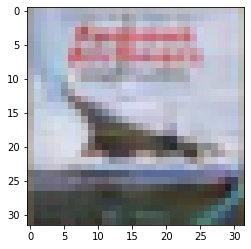

1.9999998892417459


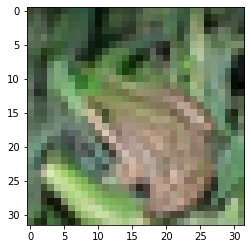

1.9999999216215256


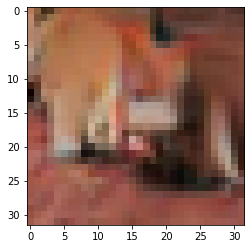

1.999999903680686


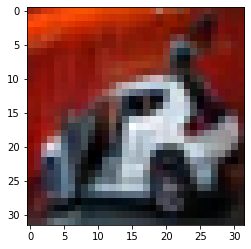

1.9999998954695075


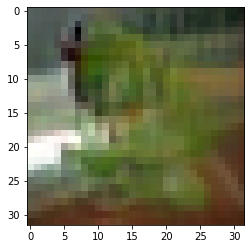

1.9999999032240767


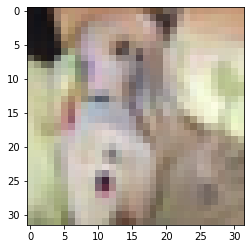

1.9999999166826508


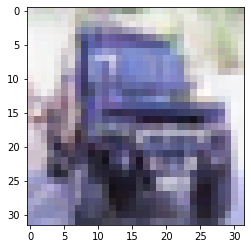

In [31]:
test = attack.generate(x_test[:128])

for i in range(10):
    print(norm(x_test[i] - test[i]))
    plt.imshow(test[i])
    plt.show()

In [23]:


for i in range(0, 128, 4):
    print(norm(x_test[i] - test[i]))

5.204604960601356
5.494351031482995
5.103363795289662
5.05073533569002
5.2633554792717225
5.756252286114137
4.955649275104176
5.732947268842704
5.174839179720812
5.063101119768573
5.8821484900622325
4.910766770076563
5.287793382002518
4.748030904769984
5.858552277972406
5.299062441451149
5.3373449430114555
5.553007123335353
5.094175075161047
5.241378246558858
5.029332814108348
5.289005006269352
6.235220130077853
6.190959098928997
6.1654507085886685
5.3017782887559495
5.901200251036498
5.462805809907195
5.201209759155052
5.361814386889475
5.532402915766574
4.975001209350393


In [ ]:
dist_matrix = np.zeros(shape=(10, 10))

for i in range(10):
    start = time.time()
    outs_1 = pen_output([dataset_train[i]])[0]
    print(i)
    for j in range(10):
        outs_2 = pen_output([attack.generate(dataset_train[j][:2000])])[0]
        norms = []
        for k in range(1000):
            norms.append(norm(outs_1[
                np.random.randint(0, 5000)] - outs_2[
                np.random.randint(0, 2000)]))
        dist_matrix[i][j] = np.mean(norms)
    end = time.time()
    print(end-start)

print(dist_matrix.round(3))

plt.imshow(dist_matrix / dist_matrix.max(), cmap="Greys")
plt.show()